In [1]:
!nvidia-smi

Sun Jan  9 11:21:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import keras
import numpy as np
import tensorflow as tf
import random as rn
import datetime
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import model_to_dot
np.random.seed(1234)
rn.seed(1234)

2.7.0
2.7.0


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


###Data Preprocessing and Normalization

In [11]:
x_train=np.load('/content/drive/My Drive/DL_Assign_2/data/x_train_2.npy')  
print(x_train.shape)

y_train=np.load("/content/drive/My Drive/DL_Assign_2/data/y_train_2.npy")
print(y_train.shape)

x_valid=np.load('/content/drive/My Drive/DL_Assign_2/data/x_valid_2.npy')
print(x_valid.shape)

y_valid=np.load("/content/drive/My Drive/DL_Assign_2/data/y_valid_2.npy")
print(y_valid.shape)

x_test=np.load("/content/drive/My Drive/DL_Assign_2/data/x_test_2.npy")
print(x_test.shape)

y_test=np.load("/content/drive/My Drive/DL_Assign_2/data/y_test_2.npy")
print(y_test.shape)

(1160, 128, 128, 3)
(1160, 128, 128)
(569, 128, 128, 3)
(569, 128, 128)
(542, 128, 128, 3)
(542, 128, 128)


In [12]:
y_train = np.reshape(y_train, (-1,128, 128,1))

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')/255

y_valid = np.reshape(y_valid, (-1,128, 128, 1))

x_valid = x_valid.astype('float32')
y_valid = y_valid.astype('float32')/255

y_test =np.reshape(y_test, (-1,128, 128,1))

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')/255

print (x_train.shape)
print (y_train.shape)
print (x_valid.shape)
print (y_valid.shape)
print (x_test.shape)
print (y_test.shape)

(1160, 128, 128, 3)
(1160, 128, 128, 1)
(569, 128, 128, 3)
(569, 128, 128, 1)
(542, 128, 128, 3)
(542, 128, 128, 1)


In [13]:
print (np.max(x_train),np.max(x_test),np.max(x_valid))
print (np.min(x_train),np.min(x_test),np.min(x_valid))

print (np.max(y_train),np.max(y_test),np.max(y_valid))
print (np.min(y_train),np.min(y_test),np.min(y_valid))

mean = np.mean(x_train)
std = np.std(x_train)

print(mean)
print(std)

x_train -= mean
x_train /= std
x_valid -= mean
x_valid /= std
x_test -= mean
x_test /= std

255.0 255.0 255.0
0.0 0.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0
33.131138
48.739983


In [14]:
np.unique(y_test)

array([0., 1.], dtype=float32)

###Data Augmentation

In [15]:
data_gen_args = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True, 
                             width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='constant')

In [16]:
image_datagen = ImageDataGenerator(data_gen_args)
mask_datagen  = ImageDataGenerator(data_gen_args)

seed = 1234
bs = 32

In [17]:
image_generator = image_datagen.flow(x_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator  = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)
train_generator = zip(image_generator, mask_generator)

###Compiling and Building the model(UNet4)

In [18]:
def create_model(learn,wt,do,act):

    inputs=Input((128,128,3))
    conv1 = Conv2D(32, 3, activation = act, padding = 'same',kernel_initializer=wt)(inputs)
    conv1 = Conv2D(32, 3, activation = act, padding = 'same',kernel_initializer=wt)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
    
    conv2 = Conv2D(64, 3, activation = act, padding = 'same',kernel_initializer=wt)(pool1)
    conv2 = Conv2D(64, 3, activation = act, padding = 'same',kernel_initializer=wt)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
       
    
    conv3 = Conv2D(128, 3, activation = act, padding = 'same',kernel_initializer=wt)(pool2)
    conv3 = Conv2D(128, 3, activation = act, padding = 'same',kernel_initializer=wt)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
   
    conv4 = Conv2D(256, 3, activation = act, padding = 'same',kernel_initializer=wt)(pool3)
    conv4 = Conv2D(256, 3,activation = act,  padding = 'same',kernel_initializer=wt)(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = act, padding = 'same',kernel_initializer=wt)(pool4)
    conv5 = Conv2D(512, 3,activation = act,  padding = 'same',kernel_initializer=wt)(conv5)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    merge6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)  

    conv6 = Conv2D(128, 3, activation = act, padding = 'same',kernel_initializer=wt)(merge6)
    conv6 = Dropout(0.5)(conv6)
    conv6 = Conv2D(128, 3, activation = act, padding = 'same',kernel_initializer=wt)(conv6)
    conv6 = BatchNormalization()(conv6)

    merge7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    
    conv7 = Conv2D(128, 3, activation = act, padding = 'same',kernel_initializer=wt)(merge7)
    conv7 = Dropout(0.5)(conv7)
    conv7 = Conv2D(128, 3, activation = act, padding = 'same',kernel_initializer=wt)(conv7)
    conv7 = BatchNormalization()(conv7)
    
    
    merge8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    
    conv8 = Conv2D(64, 3, activation = act, padding = 'same',kernel_initializer=wt)(merge8)
    conv8 = Conv2D(64, 3, activation = act, padding = 'same',kernel_initializer=wt)(conv8)
    conv8 = BatchNormalization()(conv8)
    
    merge9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    
    conv9 = Conv2D(32, 3, activation = act, padding = 'same',kernel_initializer=wt)(merge9)
    conv9 = Conv2D(32, 3, activation = act, padding = 'same',kernel_initializer=wt)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10= Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [19]:
lr=0.001  
x='he_normal' 
y=0.0    
a='relu'

model = create_model(lr,x,y,a)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [20]:
smooth=1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [24]:
import math
os.chdir('/content/drive/My Drive/DL_Assign_2/Results/')
mc  = ModelCheckpoint('/content/drive/My Drive/DL_Assign_2/Results/Exp_5/unet_exp5.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
cv  = CSVLogger('/content/drive/My Drive/DL_Assign_2/Results/Exp_5/unet_exp5.csv', separator=',', append=False)
es  = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,  mode='auto')

In [25]:
from keras import backend as K
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[dice_coef,'accuracy'])

In [26]:
history = model.fit(train_generator, steps_per_epoch=(len(x_train) // bs), epochs=50, callbacks=[mc,cv,es], validation_data=(x_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 0.3110 - dice_coef: 0.0275 - accuracy: 0.9954
Epoch 00001: val_dice_coef improved from -inf to 0.03579, saving model to /content/drive/My Drive/DL_Assign_2/Results/Exp_5/unet_exp5.h5
36/36 [==============================] - 17s 390ms/step - loss: 0.3110 - dice_coef: 0.0275 - accuracy: 0.9954 - val_loss: 0.1888 - val_dice_coef: 0.0358 - val_accuracy: 0.9835
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 0.2010 - dice_coef: 0.0409 - accuracy: 0.9984
Epoch 00002: val_dice_coef improved from 0.03579 to 0.08651, saving model to /content/drive/My Drive/DL_Assign_2/Results/Exp_5/unet_exp5.h5
36/36 [==============================] - 14s 396ms/step - loss: 0.2010 - dice_coef: 0.0409 - accuracy: 0.9984 - val_loss: 0.0902 - val_dice_coef: 0.0865 - val_accuracy: 0.9978
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 0.1286 - dice_coef: 0.0585 - accuracy: 0.9987
Epoch 00003: val_dice_coef im

###Loss and Accuracy Curve

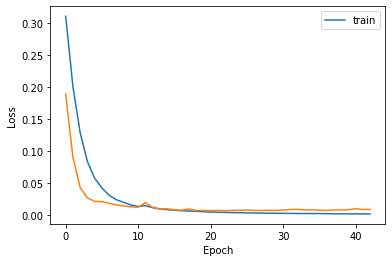

In [27]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train'])

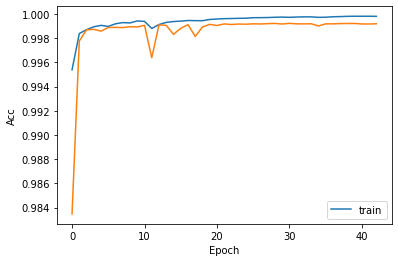

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train'])

In [29]:
!pip install medpy
from medpy.metric import dc,precision,recall

     |████████████████████████████████| 151 kB 5.4 MB/s 
     |████████████████████████████████| 48.4 MB 2.5 MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754464 sha256=6f90ca991d52d68b9f5c401c8be1902da7ad5b91aa6adc4e50e41facb3a759e8
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


###Evaluation

In [30]:
os.chdir('/content/drive/My Drive/DL_Assign_2/Results/Exp_5')
model.load_weights('unet_exp5.h5')

In [31]:
test_pred = model.predict((x_test), batch_size=32) 
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.5] = 1
test_result[test_pred<=0.5] = 0
dice = dc(test_result, y_test)
pre  = precision(test_result,y_test)
re   = recall(test_result,y_test)
print('Test Dice Coefficient: '  + str(dice))
print('Test Preceision: ' + str(pre))
print('Test Recall: '  + str(re))

Test Dice Coefficient: 0.8380153228748631
Test Preceision: 0.8882443928847641
Test Recall: 0.7931629834254144


###Vizualization

In [32]:
preds = model.predict(x_test, verbose = 1)
preds.shape
preds = np.around(preds)

17/17 [==============================] - 2s 97ms/step


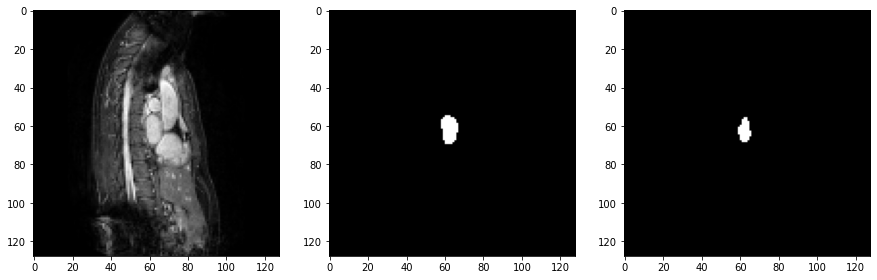

In [33]:
id = 50 #44 150 70
plt.figure(figsize = (15,15))
plt.subplot(131).imshow(x_test[id][:,:,0],cmap='gray')
plt.subplot(132).imshow(y_test[id][:,:,-1],cmap='gray')
plt.subplot(133).imshow(preds[id][:,:,-1],cmap='gray')

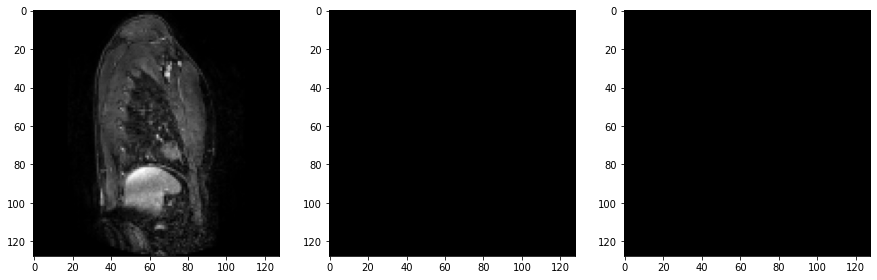

In [34]:
id = 20 #44 150 50
plt.figure(figsize = (15,15))
plt.subplot(131).imshow(x_test[id][:,:,0],cmap='gray')
plt.subplot(132).imshow(y_test[id][:,:,-1],cmap='gray')
plt.subplot(133).imshow(preds[id][:,:,-1],cmap='gray')

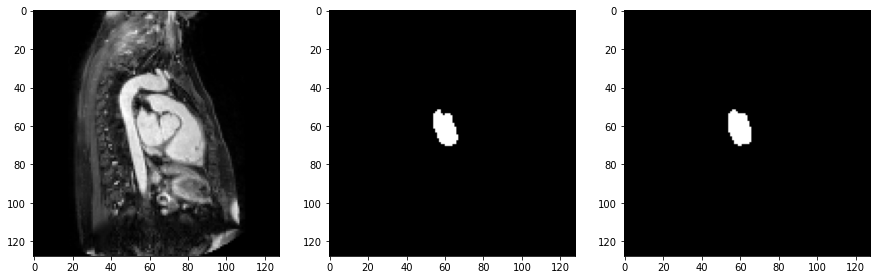

In [35]:
id = 344 #44 150 50
plt.figure(figsize = (15,15))
plt.subplot(131).imshow(x_test[id][:,:,0],cmap='gray')
plt.subplot(132).imshow(y_test[id][:,:,-1],cmap='gray')
plt.subplot(133).imshow(preds[id][:,:,-1],cmap='gray')

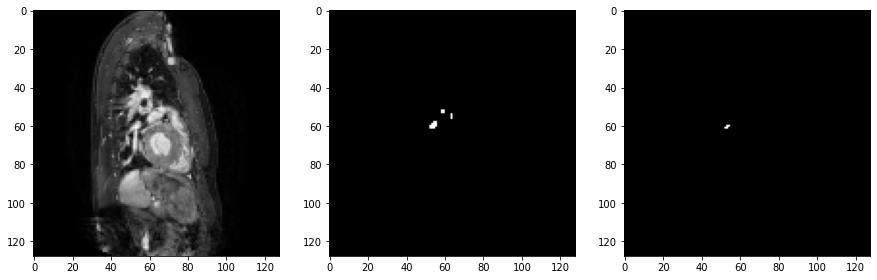

In [56]:
id = 101 #44 150 50
plt.figure(figsize = (15,15))
plt.subplot(131).imshow(x_test[id][:,:,0],cmap='gray')
plt.subplot(132).imshow(y_test[id][:,:,-1],cmap='gray')
plt.subplot(133).imshow(preds[id][:,:,-1],cmap='gray')